In [21]:
!pip install wget

Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.


In [22]:
import os
from os.path import exists
import sys
import requests
import zipfile
import wget
#sys.path.append('../utility/')
#from  utility.Dataset import Dataset as ds
#from  utility.CNN import CNN as cnn
seed=42

In [23]:
cwd = os.getcwd()
train_dir='inaturalist_12K/train/'
test_dir='inaturalist_12K/val/'
classes=['Amphibia','Animalia','Arachnida','Aves','Fungi','Insecta','Mammalia','Mollusca','Plantae','Reptilia']

In [24]:

import os
from os.path import exists
import zipfile
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random 
import cv2
import numpy as np
import pandas as pd
import keras
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
class Dataset:
    
    def downloadDataSet(self):
      cwd = os.getcwd()
     
      classes=['Amphibia','Animalia','Arachnida','Aves','Fungi','Insecta','Mammalia','Mollusca','Plantae','Reptilia']
      file_exists = exists('./nature_12K.zip')
      if(file_exists==False):
        print('downloading....')
        os.system('curl -SL https://storage.googleapis.com/wandb_datasets/nature_12K.zip > nature_12K.zip')
        print('download Complete')
      extract_exists = exists('./inaturalist_12K/')   
      if(extract_exists==False):  
        savePath=cwd
        savefile='./nature_12K.zip'
        print('Extracting..')
        with zipfile.ZipFile(savefile, 'r') as zip_ref:
            zip_ref.extractall(savePath)
        print('Complete')
       
        
    def showRandomImageOfEveryClass(self,imagesize=128):
       classes=['Amphibia','Animalia','Arachnida','Aves','Fungi','Insecta','Mammalia','Mollusca','Plantae','Reptilia']
       imagePath='./inaturalist_12K/train'
       listImages=[]
       columns = 5
       rows = 5
       imcount=1
       
       for i in classes:
           p=imagePath+'/'+i
           files=os.listdir( p)
           img=random.choice(files)
           imgplt=mpimg.imread( p+'/'+str(img))
           imgplt=cv2.resize(imgplt,(imagesize,imagesize)) 
           listImages.append(imgplt)
           #plt.imshow(imgplt)
           #fig.add_subplot(rows, columns, imcount)
           #imcount+=1
           #plt.axis('off')
           #plt.title(i) 
       
       _, axs = plt.subplots(1, 10, figsize=(15, 15))
       axs = axs.flatten()
       for img, ax,cls in zip(listImages, axs,classes):
         
           ax.imshow(img)
           ax.axis('off')
           ax.set_title(str(cls))
       plt.show()
    
    
    def import_dataset(self,seed,image_size=128,augment_data=False):
        #All variables 
        cwd=os.getcwd()
        batchsize=32
        image_size=image_size
        train_dir = './inaturalist_12K/train/'
        test_dir = './inaturalist_12K/val/'
        print('Training Dataset')

        #perform Augmentation if augment_data=True
        if augment_data:
            train_datagen = ImageDataGenerator(rescale=1./255,
                                          rotation_range=90,
                                          zoom_range=0.2,
                                          shear_range=0.2,
                                          validation_split=0.1,
                                          horizontal_flip=True)
            test_datagen = ImageDataGenerator(rescale=1./255)
        else:
            train_datagen = ImageDataGenerator(rescale=1./255,validation_split=0.1)
            test_datagen = ImageDataGenerator(rescale=1./255)

        train_ds = train_datagen.flow_from_directory(train_dir,subset="training", class_mode='sparse',color_mode='rgb',target_size=(image_size, image_size), batch_size=batchsize)
        val_ds = train_datagen.flow_from_directory(train_dir,subset="validation",class_mode='sparse', color_mode='rgb',target_size=(image_size, image_size), batch_size=batchsize)
        print('')
        print('Test Dataset')
        test_ds = test_datagen.flow_from_directory(test_dir, target_size=(image_size, image_size) ,class_mode='sparse',color_mode='rgb',batch_size=30)
    



    
        return train_ds,val_ds, test_ds
               

In [25]:
"""
Following functions used to construct an CNN network

Parameters
---------
filters: number of filters in each layer.This is mendatory parameter
size_of_filters: Size of filters in each layers
BatchNormalization: If true apply batch normalisation after each layer
number_of_neurons_dense_layer : Dense layer neuron 
number_of_classes: Total number of classes
dropout: dropout rate
BatchNormalization: Whether batch normalization applied

filterSize: 
size of filter in first layer .mostly used only when filterOrganization selected

filterOrganization:
Some default configuaration selected.Optionally user can pass there own custom filter configuration from
"filters" parameter.This is optional parameter.Values are [all_same ,incr ,decr ,alt_incr ,alt_decr ]
               
config_all_same:[64,64,64,64,64]
config_incr : [16,32,64,128,256]
config_decr: [256,128,64,32,16]
config_alt_incr: [256,128,64,32,16]   
config_alt_decr: [32,64,32,64,32]               
 
"""
import numpy as np
import pandas as pd
import os
import keras
import tensorflow as tf
from tensorflow.keras import layers,models
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Dense, Flatten, Activation , BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model
from keras.layers import Conv2D , MaxPool2D,MaxPooling3D , Flatten , Dropout, Dense, Activation, BatchNormalization
class CNN:

    def train(self,model,train_ds,val_ds,epoch=10):
        model.compile(optimizer=tf.keras.optimizers.Adam(),\
              loss=[tf.keras.losses.SparseCategoricalCrossentropy()],\
              metrics=['accuracy'])
        early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2,restore_best_weights=True)
        hist=model.fit(train_ds, epochs=epoch,validation_data=val_ds)
        return model
    def setUp(self,filters=[16,32,64,128,256],\
            size_of_filters= [(3, 3), (3, 3), (3, 3), (3, 3), (3, 3)],\
            activation_function="relu",\
            number_of_neurons_dense_layer=256,\
            number_of_classes=10,\
            dropout=0,\
            BatchNormalization=True,
            filterSize=32,
            filterOrganization='custom'
           ):
        imsize=128
        if(filterOrganization=='config_all_same'):
            filters=[64,64,64,64,64]
        if(filterOrganization=='config_incr'):
            filters=[16,32,64,128,256]
        if(filterOrganization=='config_decr'):
            filters=[256,128,64,32,16]
        if(filterOrganization=='config_alt_incr'):
            filters=[32,64,32,64,32]     
        if(filterOrganization=='config_alt_decr'):
            filters=[64,32,64,32,64]

        model = Sequential()
        num_of_filters=len(filters)
        model.add(Conv2D(filters[0], size_of_filters[0],input_shape=(imsize,imsize,3)))
        if BatchNormalization:
                model.add(tf.keras.layers.BatchNormalization()) 
        model.add(MaxPooling2D((2,2)))

        for i in range(num_of_filters-1):
            model.add(Conv2D(filters[i+1], size_of_filters[i+1]))

            model.add(Activation(activation_function))
            if BatchNormalization:
                model.add(tf.keras.layers.BatchNormalization()) 
            model.add(MaxPooling2D((2,2)))


        model.add(Flatten())

        model.add(Dense(number_of_neurons_dense_layer,activation=activation_function)) 
        if BatchNormalization:
                model.add(tf.keras.layers.BatchNormalization())
        if(dropout>0):
            model.add(Dropout(dropout))
        model.add(Dense(number_of_classes, activation='softmax'))
        return model



In [26]:
ds=Dataset()

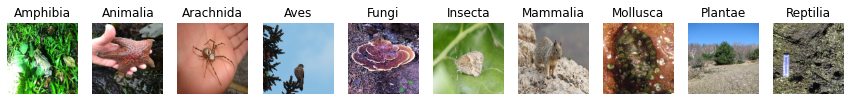

In [27]:
ds.showRandomImageOfEveryClass()

In [28]:
train_ds,val_ds,test_ds=ds.import_dataset(seed=42,augment_data=True)

Training Dataset
Found 9000 images belonging to 10 classes.
Found 999 images belonging to 10 classes.

Test Dataset
Found 2000 images belonging to 10 classes.


In [29]:
#sample inputs
cnn=CNN()
no_of_filters = [16,32,64,128,256]
activation_function="relu"
size_of_filters = [(3, 3), (3, 3), (3, 3), (3, 3), (3, 3)]
number_of_neurons_in_the_dense_layer = 256
dropout=0.3
number_of_classes=10
model=cnn.setUp(no_of_filters,size_of_filters,\
          activation_function,\
          number_of_neurons_in_the_dense_layer,\
          number_of_classes,\
          dropout,\
          filterSize=16,\
         filterOrganization='custom') 

In [30]:
model=cnn.train(model,train_ds,val_ds,2)

Epoch 1/2
282/282 [==============================] - 292s 1s/step - loss: 2.4126 - accuracy: 0.2178 - val_loss: 2.6369 - val_accuracy: 0.1281
Epoch 2/2
282/282 [==============================] - 282s 998ms/step - loss: 2.1690 - accuracy: 0.2549 - val_loss: 2.0847 - val_accuracy: 0.2723


In [31]:
model.evaluate(test_ds)

67/67 [==============================] - 28s 418ms/step - loss: 2.0020 - accuracy: 0.3085


[2.002004861831665, 0.3084999918937683]

In [32]:
randomSamples=test_ds.subset
  

In [33]:

classes=['Amphibia','Animalia','Arachnida','Aves','Fungi','Insecta','Mammalia','Mollusca','Plantae','Reptilia']
imagePath='inaturalist_12K/val/'
listImages=[]
listLabels=[]
columns = 5
rows = 5
imcount=1
clsLabel=0
for i in classes:
    p=imagePath+'/'+i
    files=os.listdir( p)
    img1=random.choice(files)
    imgplt1=mpimg.imread( p+'/'+str(img1))
    imgplt1=cv2.resize(imgplt1,(128,128)) 
    listImages.append(imgplt1)
    img2=random.choice(files)
    imgplt2=mpimg.imread( p+'/'+str(img2))
    imgplt2=cv2.resize(imgplt2,(128,128)) 
    listImages.append(imgplt2)
    img3=random.choice(files)
    imgplt3=mpimg.imread( p+'/'+str(img3))
    imgplt3=cv2.resize(imgplt3,(128,128)) 
    listImages.append(imgplt3) 
    listLabels.append(clsLabel)
    listLabels.append(clsLabel)
    listLabels.append(clsLabel)
    clsLabel+=1



In [34]:
predictions=[]
for image in listImages:
  pred=model.predict(image.reshape(1,128,128,3)).argmax()
  predictions.append(pred)

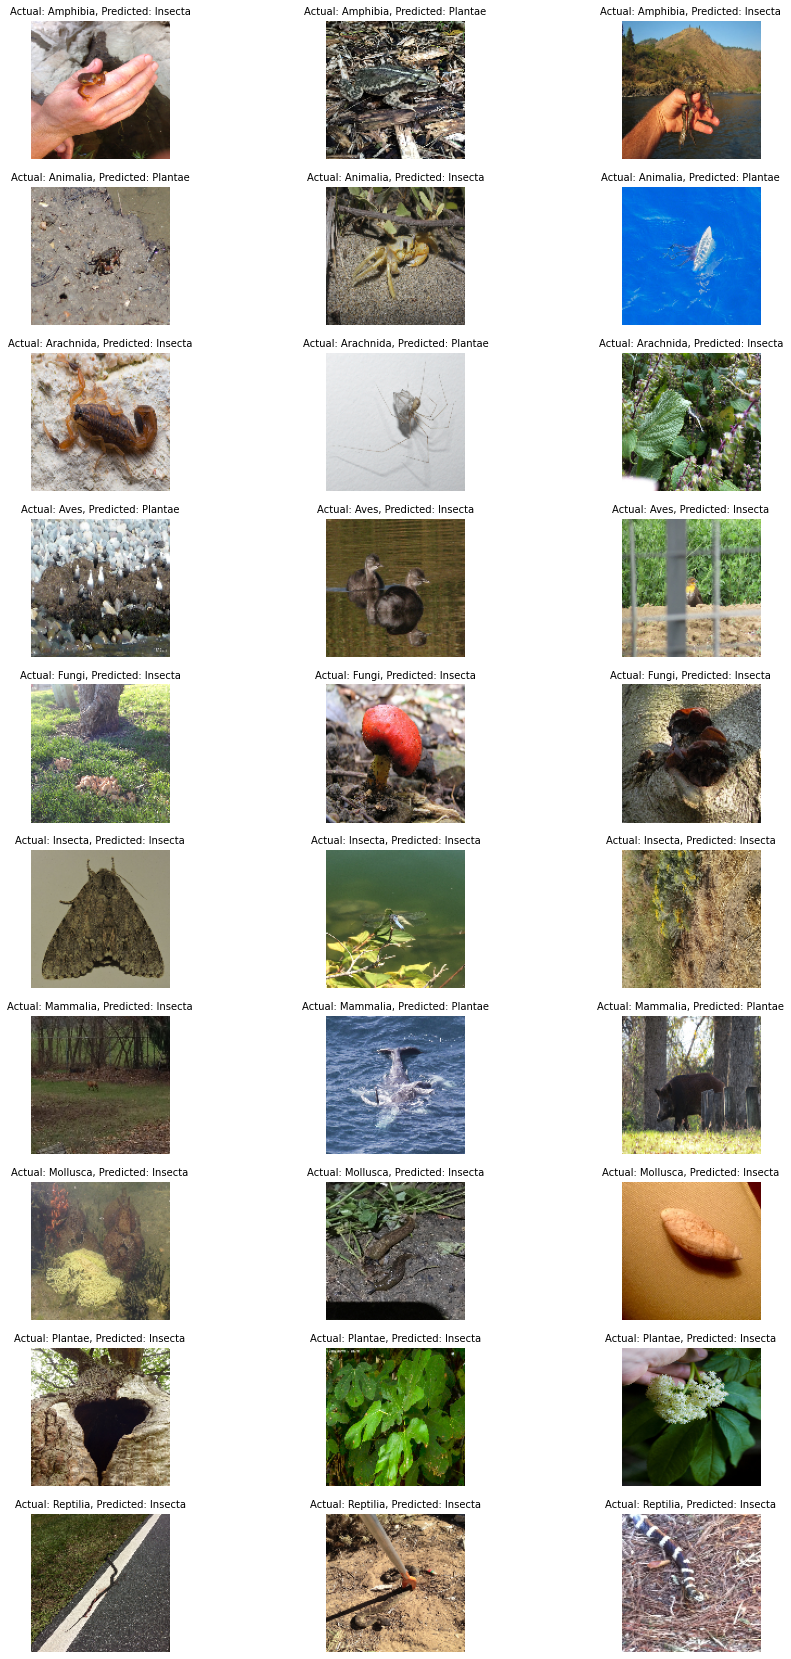

In [35]:

fig = plt.figure(figsize=(15,30))

for i in range(30):
  img=cv2.resize(listImages[i],(128,128))
  fig.add_subplot(10,3,i+1)
  plt.imshow(img)
  plt.axis('off')
  plt.title('Actual: '+str(classes[listLabels[i]])+', Predicted: '+str(classes[predictions[i]]),fontdict={'fontsize':10})
  

### Filter visualisation RGB channels

In [36]:
#Iterate thru all the layers of the model
layer= model.layers[0]
weights, bias= layer.get_weights()
filters, biases = layer.get_weights()
#print(layer.name, filters.shape)

#normalize filter values between  0 and 1 for visualization
f_min, f_max = weights.min(), weights.max()
filters = (weights - f_min) / (f_max - f_min)  



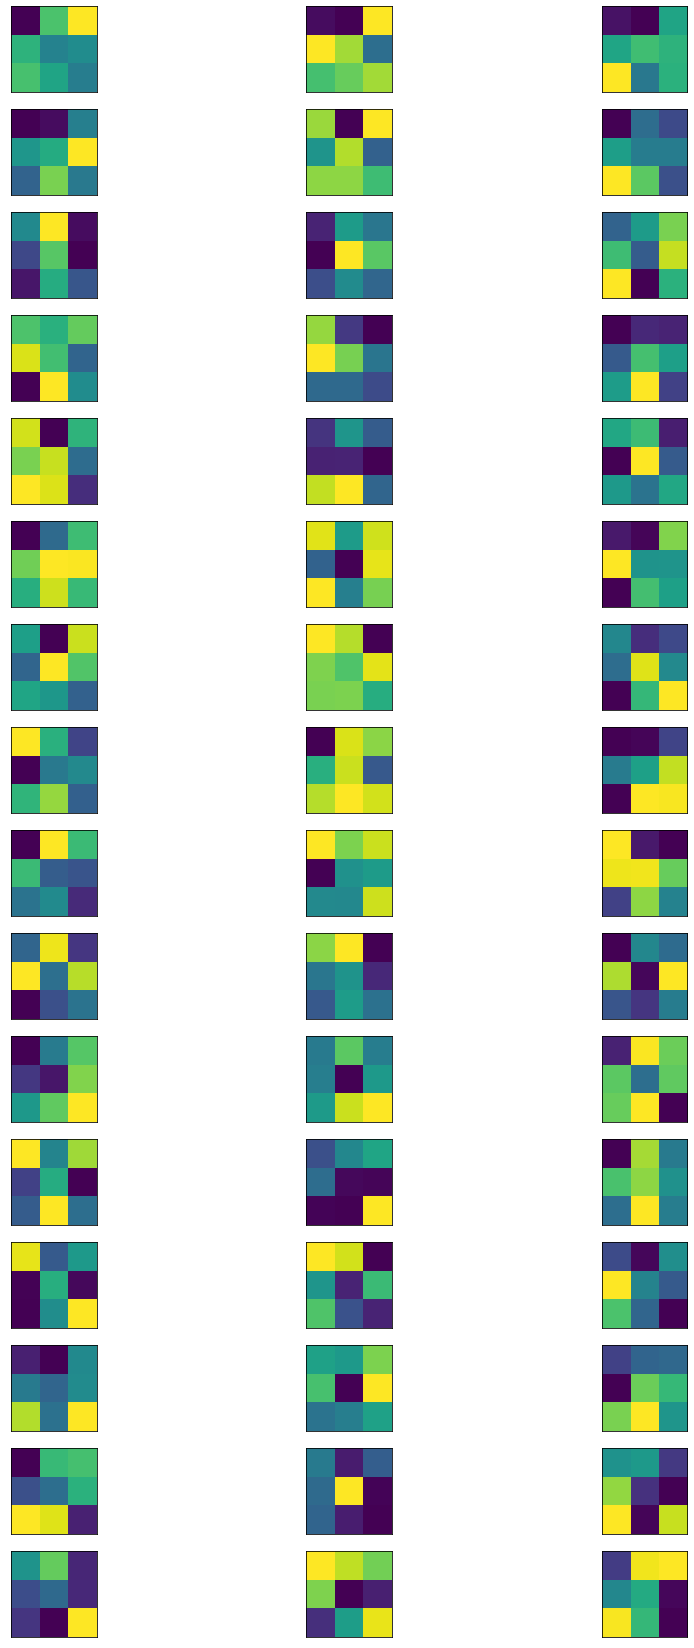

In [37]:
filter_cnt=1
fig = plt.figure(figsize=(15,30))
#plotting all the filters
for i in range(filters.shape[3]):
    #get the filters
    filt=filters[:,:,:, i]
    #plotting each of the channel, color image RGB channels
    for j in range(filters.shape[0]):
        ax= plt.subplot(filters.shape[3], filters.shape[0], filter_cnt  )
        ax.set_xticks([])
        ax.set_yticks([])
        plt.imshow(filt[:,:, j])
        filter_cnt+=1
plt.show()

### Filter Visualisation RGB channel combined

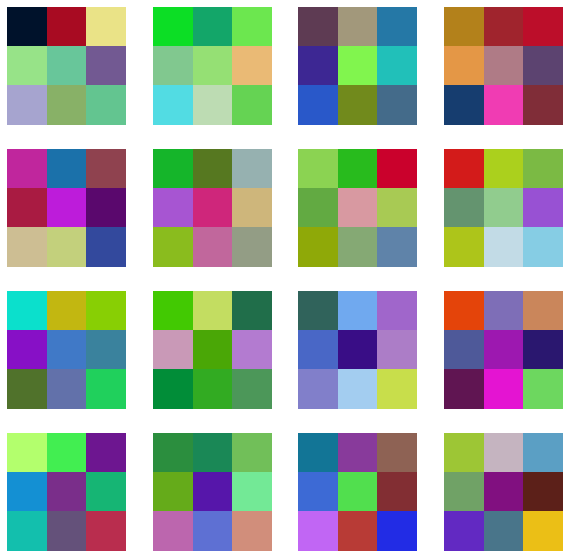

In [38]:
#The following plot shows the 16 filters in a 4x4 grid, with RGB channels combined.
filter_cnt=1
fig = plt.figure(figsize=(10,10))

#plotting all the filters
for i in range(filters.shape[3]):
    #get the filters
    filt=filters[:,:,:, i]
    fig.add_subplot(4,4,i+1)
   
    ax.set_xticks([])
    ax.set_yticks([])
    plt.imshow(filt[:,:])
    filter_cnt+=1
    plt.axis('off')
plt.show()

### Select an image for showing filter visualisation

(-0.5, 127.5, 127.5, -0.5)

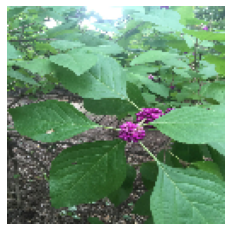

In [158]:
classes=['Amphibia','Animalia','Arachnida','Aves','Fungi','Insecta','Mammalia','Mollusca','Plantae','Reptilia']
imagePath='inaturalist_12K/val'
i=random.choice(range(len(classes)))
path=imagePath+'/'+classes[i]
files=os.listdir( path)
imgchoice=random.choice(files)
image=tf.keras.preprocessing.image.load_img(path+'/'+str(imgchoice), color_mode="rgb", target_size=(128, 128))
plt.imshow(image)
plt.axis('off')

### Feature map

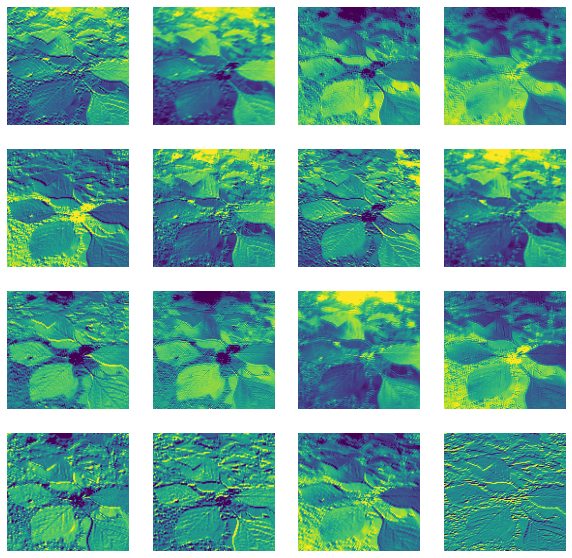

In [159]:

outputs = [layer.output for layer in model.layers[1:]]
visualization_model = tf.keras.models.Model(inputs = model.input, outputs = outputs)
x   = img_to_array(image)                           
x   = x.reshape((1,) + x.shape)
x /= 255.0

feature_maps = visualization_model.predict(x)

# Retrieve are the names of the layers
layer_names = [layer.name for layer in model.layers]
layer_name=layer_names[0]
feature_map=feature_maps[0]

 
n_features = feature_map.shape[-1]  # number of features in the feature map
size       = feature_map.shape[ 1]  # feature map shape (1, size, size, n_features)

# Postprocess the feature 
for i in range(n_features):
  x  = feature_map[0, :, :, i]
  x -= x.mean()
  x /= x.std ()
  x *=  64
  x += 128
  x  = np.clip(x, 0, 255).astype('uint8')
  feature_map[0, :, :, i]=x


fig = plt.figure(figsize=(10,10))

#plotting all the filters
for i in range(n_features):
   
    fig.add_subplot(4,4,i+1)
   
    ax.set_xticks([])
    ax.set_yticks([])
    plt.imshow(feature_map[0, :, :, i], aspect='auto')
    filter_cnt+=1
    plt.axis('off')
plt.show()



### Guided Back propogation

In [168]:

all_Conv_Layer_Names=[]
for layer in model.layers:
    if('conv' in layer.name ):
        all_Conv_Layer_Names.append(layer.name)
print(all_Conv_Layer_Names)

['conv2d_10', 'conv2d_11', 'conv2d_12', 'conv2d_13', 'conv2d_14']


In [175]:
'''create a model till  last convolutional layers to have the best compromise between high-level semantics and detailed spatial
information'''
gb_model = tf.keras.models.Model(
    inputs = [model.inputs],    
    outputs = [model.get_layer('conv2d_10').output]
)
layer_dict = [layer for layer in gb_model.layers[1:] if hasattr(layer,'activation')]

In [176]:
@tf.custom_gradient
def guidedRelu(x):
  def grad(dy):
    return tf.cast(dy>0,"float32") * tf.cast(x>0, "float32") * dy
  return tf.nn.relu(x), grad

In [185]:
for layer in layer_dict:
  if layer.activation == tf.keras.activations.relu:
    layer.activation = guidedRelu

In [184]:
with tf.GradientTape() as tape:
 inputs = tf.cast(preprocessed_input, tf.float32)
 tape.watch(inputs)
 outputs = gb_model(inputs)[0]
grads = tape.gradient(outputs,inputs)[0]

ValueError: Passed in object of type <class 'keras.engine.keras_tensor.KerasTensor'>, not tf.Tensor

In [179]:
#Visualizing the guided back prop
guided_back_prop =grads
gb_viz = np.dstack((
            guided_back_prop[:, :, 0],
            guided_back_prop[:, :, 1],
            guided_back_prop[:, :, 2],
        ))       
gb_viz -= np.min(gb_viz)
gb_viz /= gb_viz.max()
    
imgplot = plt.imshow(gb_viz)
plt.axis("off")
plt.show()

NameError: name 'grads' is not defined